In [1]:
using Plots, PlotThemes, ColorSchemes
using Statistics, Distributions
using MAT
using LinearAlgebra, ToeplitzMatrices
using FFTW
using SplitApplyCombine

theme(:juno)
default(fontfamily="times", size=(1200,600), palette=:seaborn_deep6, linewidth=2)

## Laboratorio de Filtros Kalman

Se cuenta con los datos de posición en coordenadas cartesianas $x,\,y,\,z$ de la trayectoria de un cohete sonda importados del archivo `dat_gps_vs30.mat`. Los datos están expresados en metros y son medidos con un intervalo de muestreo de $T = 1\,\text s$

In [2]:
x = matread("Data/dat_gps_vs30.mat")["pos_e"]
T = 1;

Los datos se van a analizar con un filtro de Kalman vectorial
$$\begin{aligned}
    \mathbf y[n] &= \mathbf A \mathbf y[n-1] + \mathbf I \mathbf \eta[n]\\[1em]
    \mathbf x[n] &= \mathbf H \mathbf y[n] + \nu[n]
\end{aligned}
    \qquad\text{con}\qquad
\mathbf y [n] = \begin{bmatrix}\mathbf x [n]\\[0.5em] \mathbf v[n]\\[0.5em] \mathbf a[n]\end{bmatrix} \in \mathbb R^{3\times1}
$$
Donde la matriz $\mathbf A$ es una matriz de Toeplitz triangular superior y la matriz $\mathbf H$ una matriz diagonal aumentada, definidas de la siguiente forma
$$
\mathbf A = \begin{bmatrix}
    \mathbf I_{3\times3} &     T\mathbf I_{3\times3} &    \frac{T^2}{2} \mathbf I_{3\times3}\\[0.5em]
    \mathbf 0_{3\times3} &     \mathbf I_{3\times3} &     T \mathbf I_{3\times3}\\[0.5em]
    \mathbf 0_{3\times3} &     \mathbf 0_{3\times3} &     \mathbf I_{3\times3}\\
\end{bmatrix} \in \mathbb R^{9\times9}
\qquad
\mathbf H = \begin{bmatrix}
    \mathbf I_{3\times3} &     \mathbf 0_{3\times3} &    \mathbf 0_{3\times3}\\
\end{bmatrix}\in \mathbb R^{3\times9}
$$

In [3]:
A = TriangularToeplitz([1 0 0 T 0 0 T^2/2 0 0], :U)
H = [I zeros(3, 6)];

El ruido de modelo es definido como $\mathbf \eta[n] \in \mathbb R^{9\times1}$ con correlación $C_\eta$ y el de ruido de medición como $\mathbf \nu[n] \in \mathbb R^{3\times1}$ con correlación $C_\nu$.

En función de esto definimos el filtro de Kalman

In [4]:
function kalman_vec(x; C_v, C_η, A, B, H, y0, M0)
    K = Matrix{Float64}[]
    y = Vector{Float64}[]
    M = Matrix{Float64}[]

    y_pred = A*y0
    M_pred = A*M0*A'+B*C_η*B'
    push!(K, M_pred*H'*inv(C_v+H*M_pred*H'))
    push!(y, y_pred + K[1]*(x[1,:].-H*y_pred))
    push!(M, (I-K[1]*H)*M_pred)
    
    for i = 2:size(x)[1]
        y_pred = A*y[i-1]
        M_pred = A*M[i-1]*A'+B*C_η*B'
        push!(K, M_pred*H'*inv(C_v+H*M_pred*H'))
        push!(y, y_pred + K[i]*(x[i,:].-H*y_pred))
        push!(M, (I-K[i]*H)*M_pred)
    end
    return [y, M, K]
end

kalman_vec (generic function with 1 method)

### Análisis Preliminar de los Datos

En primera instancia, se pueden visualizar los datos obteniendo la velocidad y aceleración con una derivada numérica. 

Esto permitirá saber si el resultado del filtro de Kalman es el esperado, y además permitirá obtener valores razonables para los parámetros del filtro, $C_\nu$, $C_\eta$, así como las estmaciones iniciales de $\mathbf y[0]$ y su error $\mathbf M[0]$.

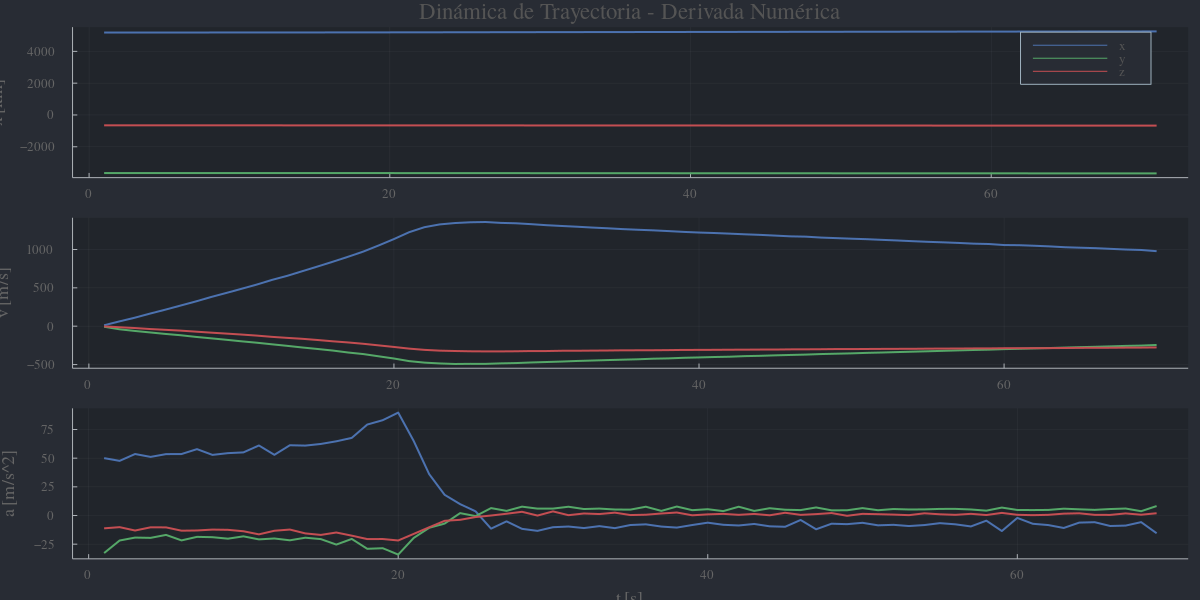

In [5]:
v = diff(x,dims=1)
a = diff(v,dims=1)

p1 = plot(x./1e3, ylabel="x [km]", label=["x" "y" "z"], title="Dinámica de Trayectoria - Derivada Numérica")
p2 = plot(v, ylabel="v [m/s]", legend=false)
p3 = plot(a, ylabel="a [m/s^2]", xlabel = "t [s]", legend=false)
plot(p1, p2, p3, layout=(3,1))

Es razonable suponer en función de estos datos un ruido de modelo no-correlacionado, en donde la varianza $\sigma_{\eta ii}^2$ es:
- Para $\mathbf x$: Máxima excursión de la velocidad
- Para $\mathbf v$: Máxima excursión de la aceleración
- Para $\mathbf a$: Máxima excursión de la derivada numérica de la aceleración

In [6]:
Var_x = v[:,1] |> maximum;
Var_v = a[:,1] |> maximum;
Var_a = diff(a[:,1],dims=1) |> maximum;
C_η=diagm([Var_x.*ones(3); Var_v.*ones(3); Var_a.*ones(3)])

9×9 Matrix{Float64}:
 1358.11     0.0      0.0    0.0     …   0.0      0.0      0.0      0.0
    0.0   1358.11     0.0    0.0         0.0      0.0      0.0      0.0
    0.0      0.0   1358.11   0.0         0.0      0.0      0.0      0.0
    0.0      0.0      0.0   89.7632      0.0      0.0      0.0      0.0
    0.0      0.0      0.0    0.0         0.0      0.0      0.0      0.0
    0.0      0.0      0.0    0.0     …  89.7632   0.0      0.0      0.0
    0.0      0.0      0.0    0.0         0.0     11.6252   0.0      0.0
    0.0      0.0      0.0    0.0         0.0      0.0     11.6252   0.0
    0.0      0.0      0.0    0.0         0.0      0.0      0.0     11.6252

In [7]:
C_v=diagm(Var_x.*ones(3))
y0 = [x[1,:]; v[1,:]; a[1,:]]
params = (C_v=C_v, C_η=C_η, A=A, B=I, H=H, y0=y0, M0=C_η)
y, M, K = kalman_vec(x; params...);

In [8]:
xs = invert(y)[1:3]
vs = invert(y)[4:6]
as = invert(y)[7:9];

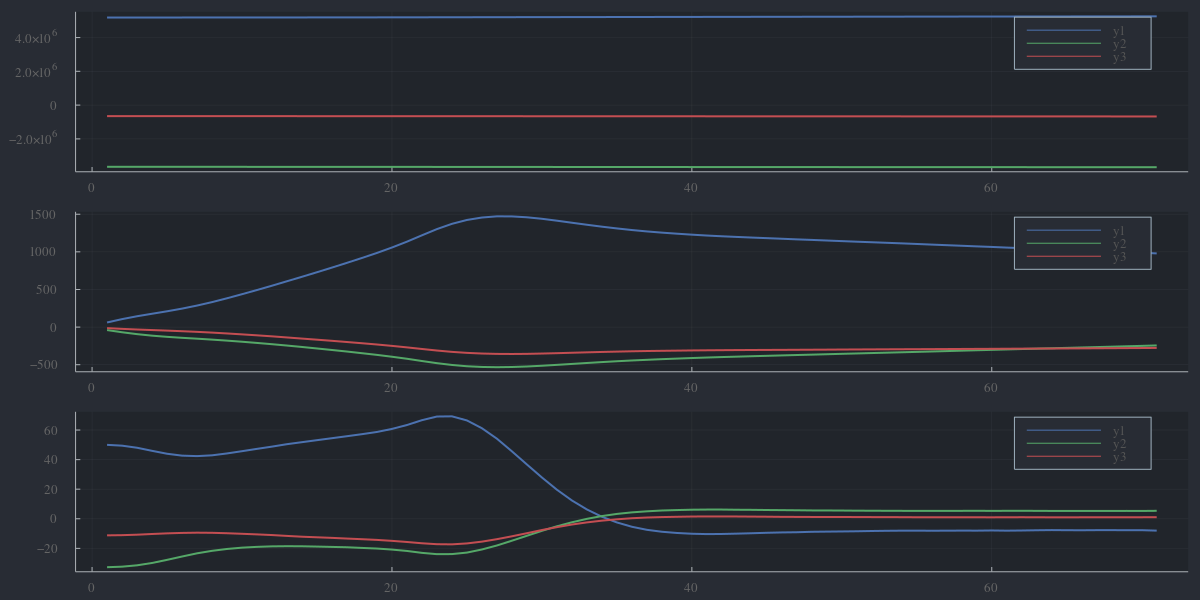

In [9]:
function plot_kalman_vec(xs, vs, as)
    p1 = plot(xs)
    p2 = plot(vs)
    p3 = plot(as)
    plot(p1, p2, p3, layout=(3,1))
end
plot_kalman_vec(xs, vs, as)

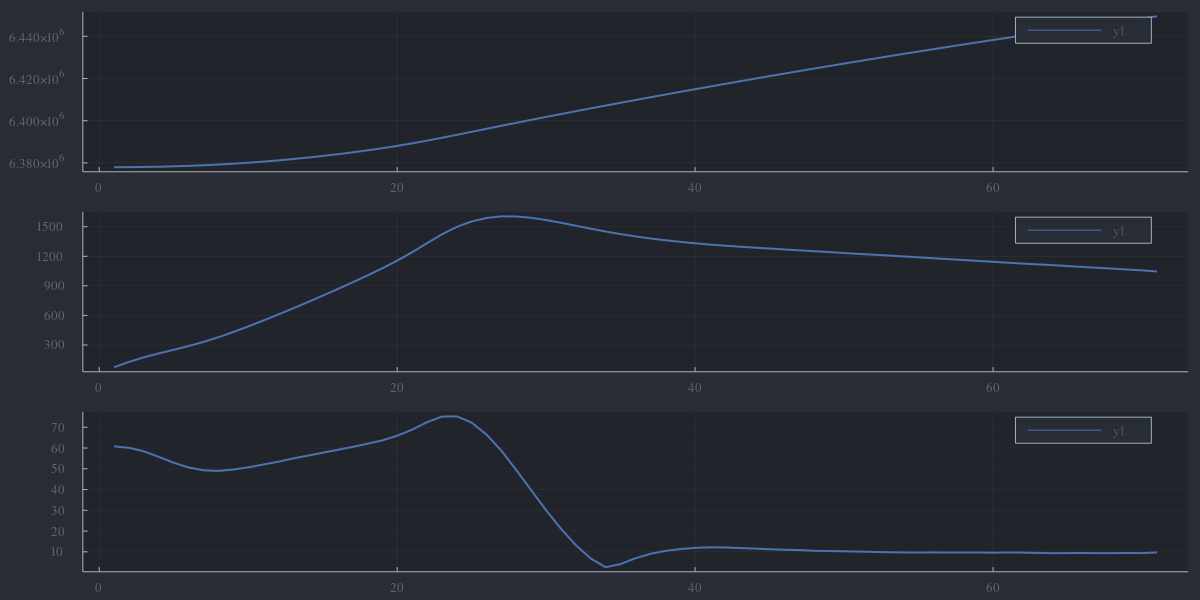

In [10]:
x = [hypot(x...) for x in invert(xs)]
v = [hypot(v...) for v in invert(vs)]
a = [hypot(a...) for a in invert(as)]
p1 = plot(x)
p2 = plot(v)
p3 = plot(a)
plot(p1, p2, p3, layout=(3,1))